In [3]:
import numpy as np
import tensorflow as tf
from keras import backend as K


In [4]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Lambda, Multiply
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.metrics import classification_report


In [9]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
%matplotlib inline

In [93]:
def plot_history(h, title):
  plt.figure(figsize= (20, 8))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(h.history['loss'], 'r', label= 'Training loss')
  plt.plot(h.history['val_loss'], 'g', label= 'Validation loss')
  plt.title(f'{title} Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(h.history['accuracy'], 'r', label= 'Training Accuracy')
  plt.plot(h.history['val_accuracy'], 'g', label= 'Validation Accuracy')
  plt.title(f'{title} Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout
  plt.show()

In [54]:
def get_data(dir):
  filepaths = []
  labels = []

  folds = os.listdir(dir)

  for fold in folds:
      foldpath = os.path.join(dir, fold)
      filelist = os.listdir(foldpath)
      for file in filelist:
          fpath = os.path.join(foldpath, file)
          filepaths.append(fpath)
          labels.append(fold)

  Fseries = pd.Series(filepaths, name='filepaths')
  Lseries = pd.Series(labels, name='labels')
  df = pd.concat([Fseries, Lseries], axis=1)
  return df

In [55]:
train_df = get_data('Training')
testing_df = get_data('Testing')

In [56]:
valid_df, test_df = train_test_split(testing_df, train_size=0.5, shuffle=True)

In [57]:
batch_size = 32
img_size = (64, 64, 3)

tr_gen = ImageDataGenerator(rescale=1 / 255)
ts_gen = ImageDataGenerator(rescale=1 / 255)

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                      class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                      class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=(img_size[0], img_size[1]),
                                     class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [94]:
def plot_cf(m, title):
  pred = m.predict(test_gen)

  y_pred = np.argmax(pred, axis=1)

  print(f'Model: {title}')
  print(classification_report(test_gen.labels, y_pred))
  print('-'*30)
  classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

  cf = confusion_matrix(test_gen.labels, y_pred)
  df_cm = pd.DataFrame(cf, index=classes,  columns=classes)
  plt.figure(figsize=(5, 5))
  plt.title(f'{title} confusion matrix')
  sns.heatmap(df_cm, annot=True, cmap='Blues', cbar=False, fmt=".1f")

# **CNN Based Classifier**

In [62]:
Cnn_classifier = tf.keras.models.Sequential([
    Input(shape=img_size),
    Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(4, activation='softmax')
    ])

In [63]:
Cnn_classifier.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 31, 31, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_20 (Conv2D)          (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 14, 14, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_8 (Flatten)         (None, 12544)             0         
                                                                 
 dense_28 (Dense)            (None, 256)              

In [64]:
Cnn_classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [65]:
history = Cnn_classifier.fit(train_gen,validation_data=valid_gen,epochs=20,verbose=1)

Epoch 1/20
179/179 [==============================] - 18s 98ms/step - loss: 0.6902 - accuracy: 0.7159 - val_loss: 0.5357 - val_accuracy: 0.7908
Epoch 2/20
179/179 [==============================] - 17s 95ms/step - loss: 0.3703 - accuracy: 0.8577 - val_loss: 0.4082 - val_accuracy: 0.8336
Epoch 3/20
179/179 [==============================] - 20s 109ms/step - loss: 0.2494 - accuracy: 0.9077 - val_loss: 0.3430 - val_accuracy: 0.8626
Epoch 4/20
179/179 [==============================] - 18s 99ms/step - loss: 0.1672 - accuracy: 0.9408 - val_loss: 0.1866 - val_accuracy: 0.9344
Epoch 5/20
179/179 [==============================] - 19s 105ms/step - loss: 0.1001 - accuracy: 0.9667 - val_loss: 0.1704 - val_accuracy: 0.9344
Epoch 6/20
179/179 [==============================] - 18s 98ms/step - loss: 0.0563 - accuracy: 0.9842 - val_loss: 0.1162 - val_accuracy: 0.9511
Epoch 7/20
179/179 [==============================] - 18s 102ms/step - loss: 0.0299 - accuracy: 0.9916 - val_loss: 0.1010 - val_accura

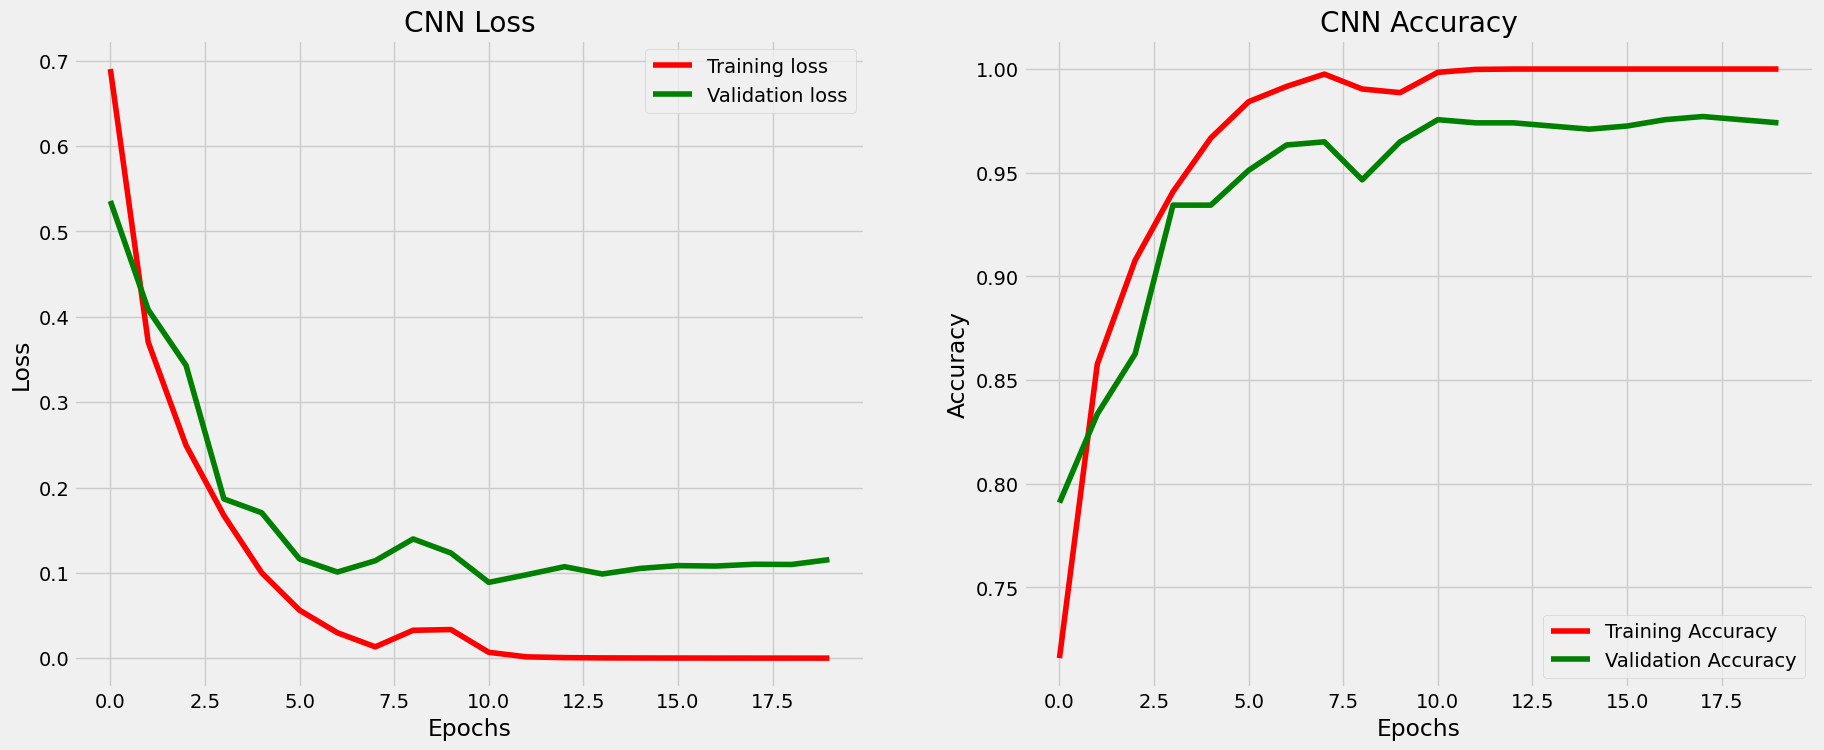

In [99]:
plot_history(history, 'CNN')

 2/21 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 [==============================] - 1s 46ms/step
Model: CNN
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       152
           1       0.93      0.94      0.93       155
           2       0.99      1.00      0.99       201
           3       0.97      0.99      0.98       148

    accuracy                           0.96       656
   macro avg       0.96      0.96      0.96       656
weighted avg       0.96      0.96      0.96       656

------------------------------


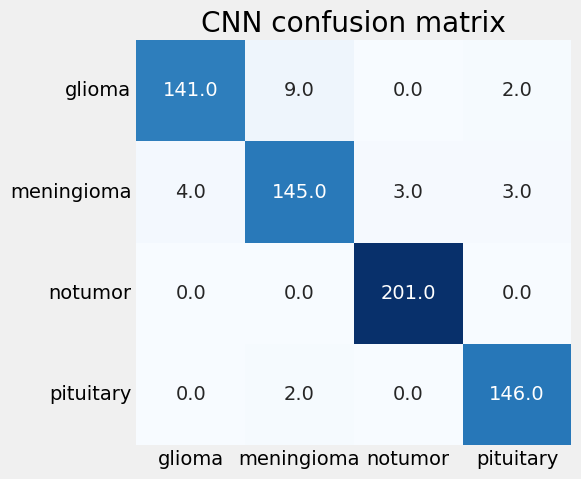

In [100]:
plot_cf(Cnn_classifier, 'CNN')

# **Capsule based classifier**

In [71]:
def squash(vectors, axis=-1):
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

In [72]:
def build_discriminator(n_routings=3):
    img = Input(shape=img_size)
    x = Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', name='conv2')(img)
    x = LeakyReLU()(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Conv2D(filters=8 * 32, kernel_size=9, strides=2, padding='valid', name='primarycap_conv2')(x)
    x = Reshape(target_shape=[-1, 8], name='primarycap_reshape')(x)
    x = Lambda(squash, name='primarycap_squash')(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Flatten()(x)
    uhat = Dense(160, kernel_initializer='he_normal', bias_initializer='zeros', name='uhat_digitcaps')(x)
    for i in range(n_routings):
        c = Activation('softmax', name='softmax_digitcaps'+str(i))(uhat)
        c = Dense(160)(c)
        x = Multiply()([uhat, c])
        s_j = LeakyReLU()(x)
    x = Dense(32,activation='relu')(s_j)
    pred = Dense(4, activation='softmax')(x)
    return Model(img, pred)

In [73]:
discriminator = build_discriminator()
discriminator.summary()
discriminator.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2 (Conv2D)              (None, 56, 56, 256)          62464     ['input_5[0][0]']             
                                                                                                  
 leaky_re_lu_4 (LeakyReLU)   (None, 56, 56, 256)          0         ['conv2[0][0]']               
                                                                                                  
 batch_normalization_19 (Ba  (None, 56, 56, 256)          1024      ['leaky_re_lu_4[0][0]']       
 tchNormalization)                                                                          

In [74]:
tf.config.run_functions_eagerly(True)

In [75]:
caps_history = discriminator.fit(train_gen,validation_data=valid_gen,epochs=20,verbose=1)

Epoch 1/20
179/179 [==============================] - 35s 194ms/step - loss: 1.6440 - accuracy: 0.5221 - val_loss: 0.9671 - val_accuracy: 0.6351
Epoch 2/20
179/179 [==============================] - 34s 190ms/step - loss: 0.8772 - accuracy: 0.6873 - val_loss: 1.1058 - val_accuracy: 0.6687
Epoch 3/20
179/179 [==============================] - 34s 187ms/step - loss: 0.7053 - accuracy: 0.7386 - val_loss: 0.6832 - val_accuracy: 0.7389
Epoch 4/20
179/179 [==============================] - 33s 186ms/step - loss: 0.6677 - accuracy: 0.7750 - val_loss: 0.6094 - val_accuracy: 0.7634
Epoch 5/20
179/179 [==============================] - 35s 194ms/step - loss: 0.6443 - accuracy: 0.7728 - val_loss: 0.7934 - val_accuracy: 0.7252
Epoch 6/20
179/179 [==============================] - 33s 183ms/step - loss: 0.5782 - accuracy: 0.7806 - val_loss: 0.5813 - val_accuracy: 0.7695
Epoch 7/20
179/179 [==============================] - 34s 191ms/step - loss: 0.3995 - accuracy: 0.8531 - val_loss: 0.4466 - val_ac

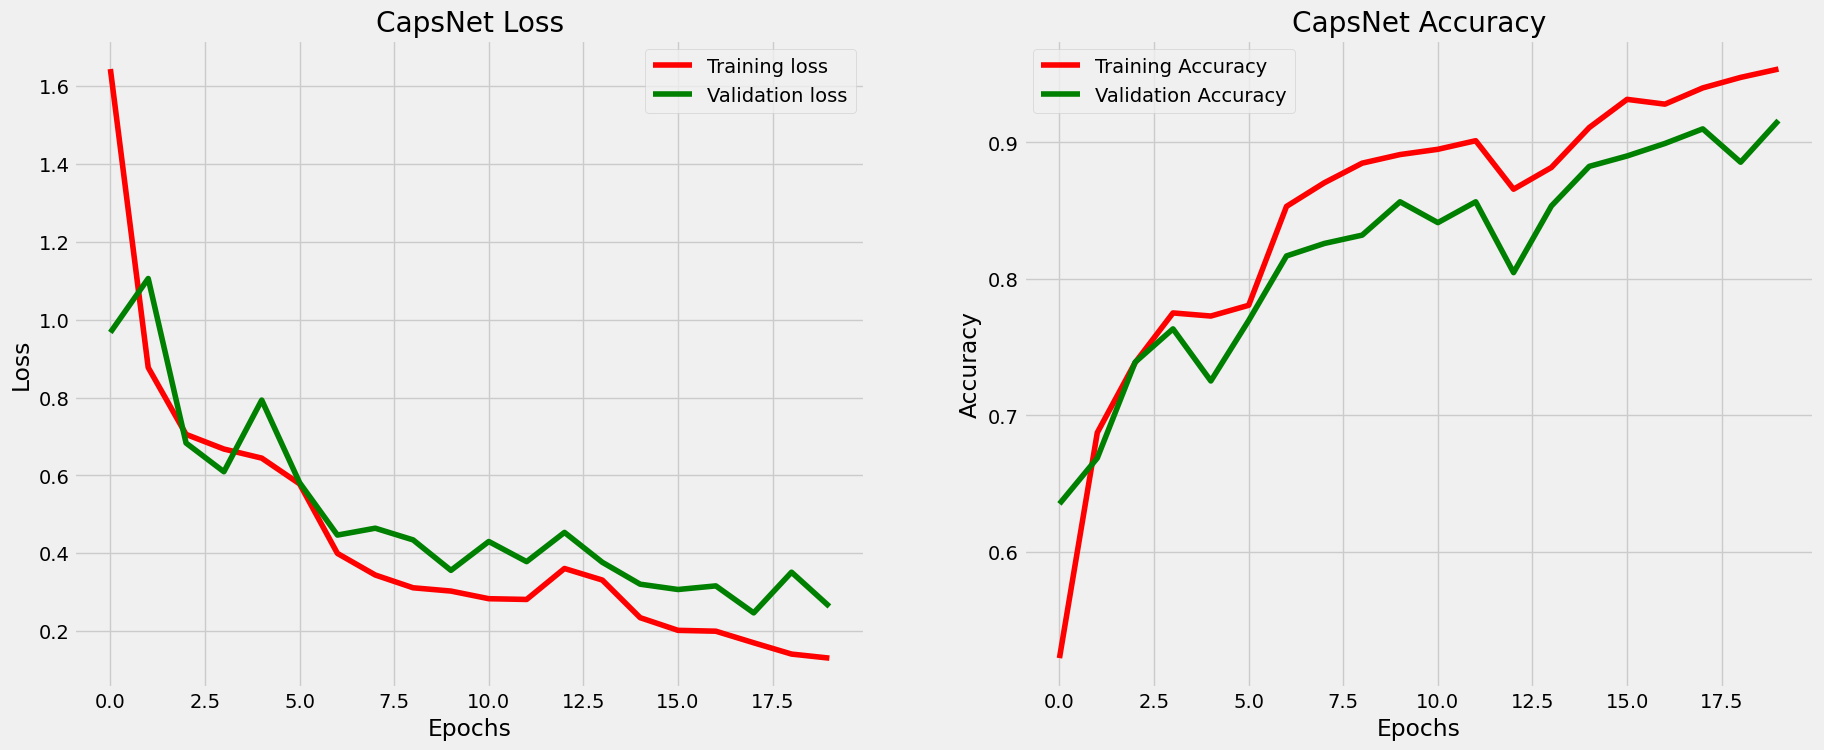

In [97]:
plot_history(caps_history, 'CapsNet')

 2/21 [=>............................] - ETA: 1s

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 [==============================] - 1s 55ms/step
Model: CapsNet
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       152
           1       0.85      0.70      0.77       155
           2       0.96      0.98      0.97       201
           3       0.90      0.99      0.94       148

    accuracy                           0.90       656
   macro avg       0.89      0.89      0.89       656
weighted avg       0.89      0.90      0.89       656

------------------------------


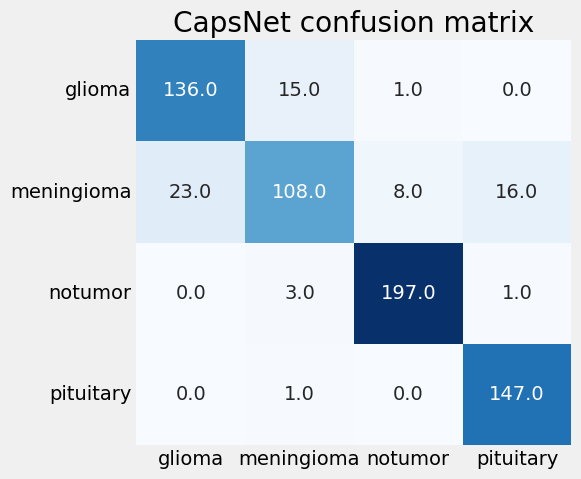

In [98]:
plot_cf(discriminator, 'CapsNet')

###ViT

In [86]:
pip install vit-keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 2.5 MB/s eta 0:00:00


In [88]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.9 MB/s eta 0:00:00


In [91]:
from vit_keras import vit
vit_model = vit.vit_b16(
    image_size=img_size[0],
    activation='softmax',
    pretrained=True,
    include_top=True,
    classes=4,
    pretrained_top=False,
)

vit_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

vit_model.summary()

/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 4, 4
  warnings.warn(


Model: "vit-b16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 embedding (Conv2D)          (None, 4, 4, 768)         590592    
                                                                 
 reshape_1 (Reshape)         (None, 16, 768)           0         
                                                                 
 class_token (ClassToken)    (None, 17, 768)           768       
                                                                 
 Transformer/posembed_input  (None, 17, 768)           13056     
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 17, 768),         7087872   
  (TransformerBlock)          (None, 12, None, None)       

In [92]:
vit_history = vit_model.fit(train_gen, epochs=20, verbose=1, validation_data=valid_gen, shuffle=False)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


179/179 [==============================] - 200s 1s/step - loss: 1.2301 - accuracy: 0.4841 - val_loss: 0.9256 - val_accuracy: 0.6321
Epoch 2/20
179/179 [==============================] - 198s 1s/step - loss: 0.6667 - accuracy: 0.7419 - val_loss: 0.6573 - val_accuracy: 0.7420
Epoch 3/20
179/179 [==============================] - 198s 1s/step - loss: 0.5131 - accuracy: 0.8041 - val_loss: 0.5701 - val_accuracy: 0.7328
Epoch 4/20
179/179 [==============================] - 197s 1s/step - loss: 0.4548 - accuracy: 0.8216 - val_loss: 0.4904 - val_accuracy: 0.7908
Epoch 5/20
179/179 [==============================] - 197s 1s/step - loss: 0.3573 - accuracy: 0.8627 - val_loss: 0.4282 - val_accuracy: 0.8321
Epoch 6/20
179/179 [==============================] - 194s 1s/step - loss: 0.3507 - accuracy: 0.8682 - val_loss: 0.3681 - val_accuracy: 0.8534
Epoch 7/20
179/179 [==============================] - 197s 1s/step - loss: 0.3112 - accuracy: 0.8834 - val_loss: 0.5289 - val_accuracy: 0.8107
Epoch 8/20

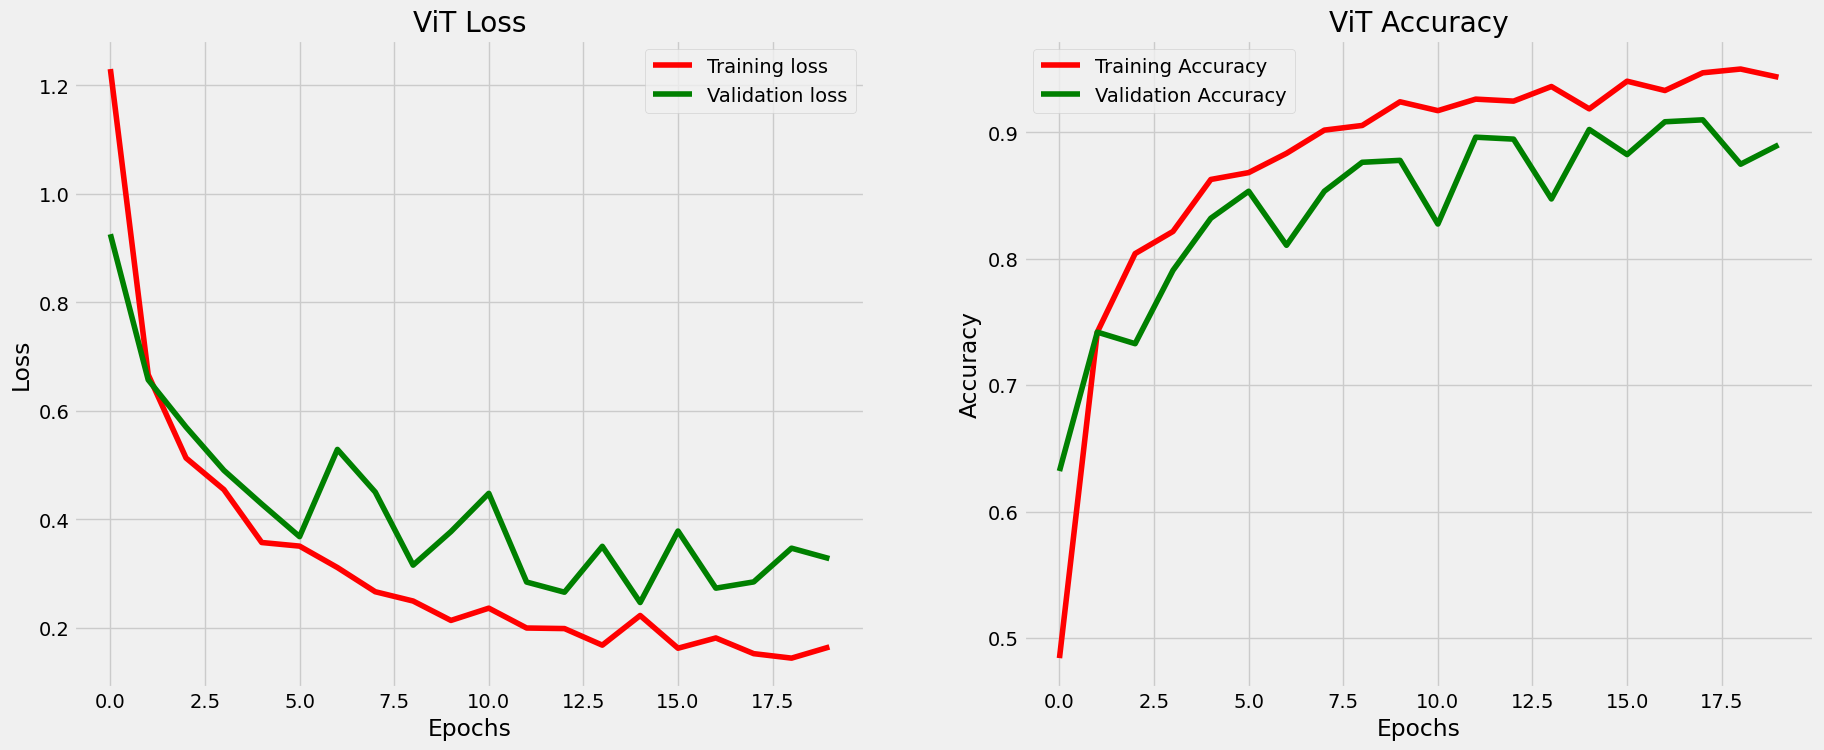

In [95]:
plot_history(vit_history, 'ViT')

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


21/21 [==============================] - 5s 240ms/step
Model: ViT
              precision    recall  f1-score   support

           0       0.96      0.72      0.82       152
           1       0.75      0.89      0.82       155
           2       0.95      0.99      0.97       201
           3       0.95      0.96      0.96       148

    accuracy                           0.90       656
   macro avg       0.90      0.89      0.89       656
weighted avg       0.91      0.90      0.90       656

------------------------------


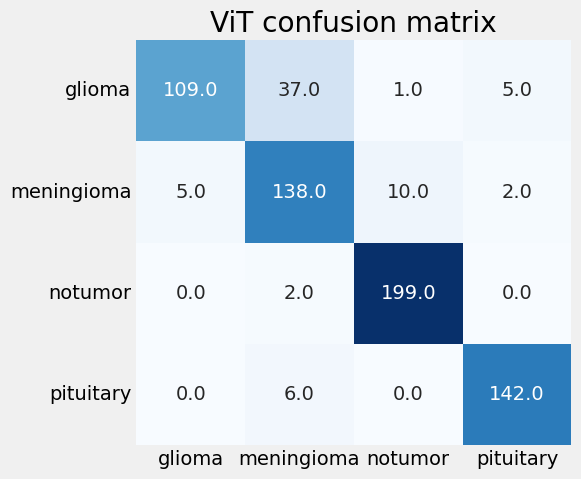

In [96]:
plot_cf(vit_model, 'ViT')